## **ИТОГОВЫЙ ПРОЕКТ**
### **по теме "Image2Image - Генерация изображений"**
### *куратор проекта Балаганов Никита*

#### ***Проект подготовил:***
#### ***слушатель 1 части курса (для продвинутого и базового потоков)***
#### ***Белов Юрий (stepik ID: 21313451)***

## CycleGAN
--------------------------------------------


### Реализация архитектуры для CycleGAN модели

CycleGAN модель обучаем на переработанном датасете лошади и зебры "horse2zebra".

In [ ]:
### Вначале импортируем основные библиотеки ###

# Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F
# from torch.nn import functional as F

import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms, models
from torchvision.transforms import ToPILImage

import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

from torchvision import models
import torch.optim as optim
from torch.optim import SGD, Adam, lr_scheduler

import torchsummary
from torchsummary import summary # чтобы смотреть описание модели и её параметров

import time
from time import time
import logging
import threading

import math

import os
import glob
# import rglob
from glob import glob

from pathlib import Path

from os import listdir
from os.path import isfile, join

import pickle
from skimage import io
from skimage.io import imread

import numpy as np
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder

import itertools
from IPython.display import clear_output
import copy
from copy import deepcopy

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, поэтому, чтобы в colab было удобно выводить картинки, 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
### Подключаем свой гугл диск!

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
##### !unzip -q /content/gdrive/My\ Drive/horse2zebra_.zip

!unzip -q /content/gdrive/MyDrive/DLS_MFTI_CycleGAN/horse2zebra_.zip

In [ ]:
!ls horse2zebra_

testA  testB  trainA  trainB


In [ ]:
import PIL
# импортируем, если не импортировали выше

# print(PIL.PILLOW_VERSION)
PIL.__version__

# Здесь должна быть версия pillow 5.3.0. или выше, если это не так, то надо установить требуемую версию
# и перезагрузить потом данный ноутбук:
# Menu > Runtime > Restart Runtime

'7.1.2'

In [ ]:
'''
# ВНИМАНИЕ: если версия Pillow установлена по умолчанию - '7.0.0', то требуется её переустановить на '5.3.0',
# так как версия '7.0.0' ломает torchvision.

!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

'''

In [ ]:
'''
import PIL
# импортируем, если не импортировали выше

# print(PIL.PILLOW_VERSION)
PIL.__version__

'''

'5.3.0'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Sun Jun 27 13:50:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Очистить кэш предварительно перед обучением

torch.cuda.empty_cache()

In [ ]:
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Использование CuDNN Backend
# Вы можете использовать cudnn benchmark вместо vanilla benchmark. 
# CuDNN может обеспечить большую оптимизацию, которая может снизить использование вашего пространства, 
# особенно когда вход в вашу нейронную сеть имеет фиксированный размер.

### torch.backends.cudnn.benchmark = True
### torch.backends.cudnn.enabled = True

In [ ]:
# !pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.2
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2021.5.30
cffi==1.14.5
cftime==1.5.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==9.1.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==1.25.3
dlib==1

In [ ]:
class dataset (Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.len_ = len(self.files)
        self.mode = mode

    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        # image = Image.open(file)
        image = Image.open(file).convert('RGB')
        image.load()
        # return image.convert('RGB')
        return image

  
    def __getitem__(self, index):

        if self.mode == 'test':

            x = self.load_sample(self.files[index])

            # x = self._prepare_sample(x)
            x = np.array(x)

            x = np.array(x / 255, dtype='float32')

            # для преобразования изображений в тензоры PyTorch и нормализации входа
            trans = transforms.Compose([
                                    # transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    # transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                                   ])

            x = trans(x)

            return x
        
        elif self.mode == 'train':

            x = self.load_sample(self.files[index])

            ### В этом месте добавлена аугментация изображений ###
            x = self._augmentation_image(x)

            # x = self._prepare_sample(x)
            x = np.array(x)

            x = np.array(x / 255., dtype='float32')

            trans = transforms.Compose([
                                    # transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    # transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                                   ])
            
            x = trans(x)
            
            return x

    
    def _prepare_sample(self, image):

        # все изображения будут масштабированы к размеру 256x256 px
        RESCALE_SIZE = 256
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))

        return np.array(image)
        # return image


    def _augmentation_image(self, image):

        # все изображения будут масштабированы к размеру 256x256 px
        # RESCALE_SIZE = 256
        # image = image.resize((RESCALE_SIZE, RESCALE_SIZE))

        ### В этом месте добавлена аугментация изображений ###
            
        trans_augment = transforms.Compose([transforms.Resize((256, 256)),
                                            # transforms.CenterCrop(224),
                                            # transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(), 
                                            transforms.RandomRotation([-10, 10]), 
                                            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                                            ])
        
        x = trans_augment(image)

        return x

In [ ]:
'''
dir_train_A = Path('horse2zebra_/trainA')
dir_train_B = Path('horse2zebra_/trainB')
dir_test_A = Path('horse2zebra_/testA')
dir_test_B = Path('horse2zebra_/testB')

train_A = sorted(list(dir_train_A.rglob('*.jpg')))
train_B = sorted(list(dir_train_B.rglob('*.jpg')))
test_A = sorted(list(dir_test_A.rglob('*.jpg')))
test_B = sorted(list(dir_test_B.rglob('*.jpg')))

dataset_train_A = dataset(train_A, mode = 'train')
dataset_train_B = dataset(train_B, mode = 'train')
dataset_test_A = dataset(test_A, mode = 'test')
dataset_test_B = dataset(test_B, mode = 'test')

'''

In [ ]:
'''
batch_size = 4

data_train_A = DataLoader(dataset_train_A, batch_size = batch_size, shuffle = True)
data_train_B = DataLoader(dataset_train_B, batch_size = batch_size, shuffle = True)
data_test_A = DataLoader(dataset_test_A, batch_size = batch_size, shuffle = False)
data_test_B = DataLoader(dataset_test_B, batch_size = batch_size, shuffle = False)

'''

In [ ]:
'''
print('trainA = ', len(train_A))
print('trainB = ', len(train_B))
print('testA = ', len(test_A))
print('testB = ', len(test_B))

'''

trainA =  1332
trainB =  1332
testA =  140
testB =  140


### Модель CycleGAN


In [ ]:
####### Модель CycleGAN #######

### Residual-блоки, которые расположены в модели генератора между слоями Downsampling и Upsampling ###

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


### Класс генератора модели CycleGAN ###

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


### Класс дескриминатора модели CycleGAN ###

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]
        # model += [nn.Conv2d(512, 3, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        # return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size(0), -1)


In [ ]:
### Создадим модели дескриминаторов D1 и D2 ###

D1 = Discriminator(3).cuda()
D2 = Discriminator(3).cuda()

# D1 = Discriminator(3).cpu()
# D2 = Discriminator(3).cpu()

In [ ]:
### Проверим, что в модели дескриминатора D1 те слои, которые нам нужны. ###

print(D1) # просмотр слоев модели D1

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)


In [ ]:
### Проверим, что в модели дескриминатора D2 те слои, которые нам нужны. ###

print(D2) # просмотр слоев модели D2

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)


In [ ]:
### Посмотрим размеры выходных тензоров у созданной модели дескриминатора D1 ###

torchsummary.summary(D1, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-10          [-1, 512, 31, 31]               0
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
---------------------------

In [ ]:
### Посмотрим размеры выходных тензоров у созданной модели дескриминатора D2 ###

torchsummary.summary(D2, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-10          [-1, 512, 31, 31]               0
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
---------------------------

In [ ]:
# list(D1.parameters())

In [ ]:
# list(D2.parameters())

In [ ]:
### Создадим модели генераторов GA2B и GB2A ###

GA2B = Generator(3, 3).cuda()
GB2A = Generator(3, 3).cuda()

# GA2B = Generator(3, 3).cpu()
# GB2A = Generator(3, 3).cpu()

In [ ]:
### Проверим, что в модели генератора GA2B те слои, которые нам нужны. ###

print(GA2B) # просмотр слоев модели GA2B

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (

In [ ]:
### Проверим, что в модели генератора GB2A те слои, которые нам нужны. ###

print(GB2A) # просмотр слоев модели GB2A

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (

In [ ]:
### Посмотрим размеры выходных тензоров у созданной модели генератора GA2B ###

torchsummary.summary(GA2B, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

In [ ]:
### Посмотрим размеры выходных тензоров у созданной модели генератора GB2A ###

torchsummary.summary(GB2A, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

In [ ]:
# list(GA2B.parameters())

In [ ]:
# list(GB2A.parameters())

In [ ]:
### Подгружаем раннее сохраненные веса ###
### Применяем, если были сбросы при работе в Colabe или хотим вернуться к ранее сохраненному состоянию нашей модели !!!

# GA2B.load_state_dict(torch.load("gdrive/My Drive/GA2B.pth"))
# GB2A.load_state_dict(torch.load("gdrive/My Drive/GB2A.pth"))
# D1.load_state_dict(torch.load("gdrive/My Drive/D1.pth"))
# D2.load_state_dict(torch.load("gdrive/My Drive/D2.pth"))

GA2B.load_state_dict(torch.load("gdrive/My Drive/DLS_MFTI_CycleGAN/GA2B.pth"))
GB2A.load_state_dict(torch.load("gdrive/My Drive/DLS_MFTI_CycleGAN/GB2A.pth"))
D1.load_state_dict(torch.load("gdrive/My Drive/DLS_MFTI_CycleGAN/D1.pth"))
D2.load_state_dict(torch.load("gdrive/My Drive/DLS_MFTI_CycleGAN/D2.pth"))

<All keys matched successfully>

In [ ]:
for name, param in GA2B.named_parameters():
    print(name, ':', param.requires_grad)

model.1.weight : True
model.1.bias : True
model.4.weight : True
model.4.bias : True
model.7.weight : True
model.7.bias : True
model.10.conv_block.1.weight : True
model.10.conv_block.1.bias : True
model.10.conv_block.5.weight : True
model.10.conv_block.5.bias : True
model.11.conv_block.1.weight : True
model.11.conv_block.1.bias : True
model.11.conv_block.5.weight : True
model.11.conv_block.5.bias : True
model.12.conv_block.1.weight : True
model.12.conv_block.1.bias : True
model.12.conv_block.5.weight : True
model.12.conv_block.5.bias : True
model.13.conv_block.1.weight : True
model.13.conv_block.1.bias : True
model.13.conv_block.5.weight : True
model.13.conv_block.5.bias : True
model.14.conv_block.1.weight : True
model.14.conv_block.1.bias : True
model.14.conv_block.5.weight : True
model.14.conv_block.5.bias : True
model.15.conv_block.1.weight : True
model.15.conv_block.1.bias : True
model.15.conv_block.5.weight : True
model.15.conv_block.5.bias : True
model.16.conv_block.1.weight : Tru

In [ ]:
for name, param in GB2A.named_parameters():
    print(name, ':', param.requires_grad)

model.1.weight : True
model.1.bias : True
model.4.weight : True
model.4.bias : True
model.7.weight : True
model.7.bias : True
model.10.conv_block.1.weight : True
model.10.conv_block.1.bias : True
model.10.conv_block.5.weight : True
model.10.conv_block.5.bias : True
model.11.conv_block.1.weight : True
model.11.conv_block.1.bias : True
model.11.conv_block.5.weight : True
model.11.conv_block.5.bias : True
model.12.conv_block.1.weight : True
model.12.conv_block.1.bias : True
model.12.conv_block.5.weight : True
model.12.conv_block.5.bias : True
model.13.conv_block.1.weight : True
model.13.conv_block.1.bias : True
model.13.conv_block.5.weight : True
model.13.conv_block.5.bias : True
model.14.conv_block.1.weight : True
model.14.conv_block.1.bias : True
model.14.conv_block.5.weight : True
model.14.conv_block.5.bias : True
model.15.conv_block.1.weight : True
model.15.conv_block.1.bias : True
model.15.conv_block.5.weight : True
model.15.conv_block.5.bias : True
model.16.conv_block.1.weight : Tru

In [ ]:
for name, param in D1.named_parameters():
    print(name, ':', param.requires_grad)

model.0.weight : True
model.0.bias : True
model.2.weight : True
model.2.bias : True
model.5.weight : True
model.5.bias : True
model.8.weight : True
model.8.bias : True
model.11.weight : True
model.11.bias : True


In [ ]:
for name, param in D2.named_parameters():
    print(name, ':', param.requires_grad)

model.0.weight : True
model.0.bias : True
model.2.weight : True
model.2.bias : True
model.5.weight : True
model.5.bias : True
model.8.weight : True
model.8.bias : True
model.11.weight : True
model.11.bias : True


### Обучение (train) наших моделей

In [ ]:
##### Функция TRAIN для нашей сети, состоящей из моделей дескриминаторов D1, D2 и генераторов GA2B, GB2A #####

def train(GA2B, GB2A, D1, D2, num_epochs, data_train_A, data_train_B, batch_size, lamb, loss_g, loss_d):

    # Очистить кэш предварительно перед обучением
    torch.cuda.empty_cache()

    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # train mode
    GA2B.train() # переводим модель в режим training
    GB2A.train() # переводим модель в режим training
    D1.train() # переводим модель в режим training
    D2.train() # переводим модель в режим training

    # Оптимизатор AdamW
    optimizer_g = torch.optim.AdamW(itertools.chain(GA2B.parameters(), GB2A.parameters()), lr = 0.0001, betas=(0.9,0.99), eps=1e-08, amsgrad=False)
    optimizer_d1 = torch.optim.AdamW(D1.parameters(), lr = 0.0001, betas=(0.9,0.99), eps=1e-08, amsgrad=False)
    optimizer_d2 = torch.optim.AdamW(D2.parameters(), lr = 0.0001, betas=(0.9,0.99), eps=1e-08, amsgrad=False)

    ### Здесь добавлена схема изменения learning rate ###
    ### Для этого добавлен scheduler ###

    lambda_g = lambda epoch: pow((1-((epoch-1)/(num_epochs))), 0.9)
    scheduler_g = lr_scheduler.LambdaLR(optimizer_g, lr_lambda=lambda_g) # learning rate changed every epoch

    lambda_d1 = lambda epoch: pow((1-((epoch-1)/(num_epochs))), 0.9)
    scheduler_d1 = lr_scheduler.LambdaLR(optimizer_d1, lr_lambda=lambda_d1) # learning rate changed every epoch

    lambda_d2 = lambda epoch: pow((1-((epoch-1)/(num_epochs))), 0.9)
    scheduler_d2 = lr_scheduler.LambdaLR(optimizer_d2, lr_lambda=lambda_d2) # learning rate changed every epoch


    losses = [[], []]
    i = 0
    epoch = 0

    ### for epoch in range(0, num_epochs):
    for epoch in range(num_epochs):

        # Очищать кэш GPU каждую эпоху обучения
        # torch.cuda.empty_cache()

        # tic = time()
        # print('* Epoch %d/%d' % (epoch+1, num_epochs))

        scheduler_g.step(epoch)
        scheduler_d1.step(epoch)
        scheduler_d2.step(epoch)
      
        loss = [[], []]

        # train mode
        # GA2B.train()
        # GB2A.train()
        # D1.train()
        # D2.train()

        for x, Y in zip(data_train_A, data_train_B):  

            optimizer_g.zero_grad()

            for param in GA2B.parameters():
                param.requires_grad = True
            for param in GB2A.parameters():
                param.requires_grad = True
            for param in D1.parameters():
                param.requires_grad = False
            for param in D2.parameters():
                param.requires_grad = False

            x, Y = x.to(device), Y.to(device)
            X, y = x.to(device), Y.to(device)

            real_y = GA2B(y).to(device)
            loss_y2y = loss_g(real_y, y)
            real_x = GB2A(X).to(device)
            loss_x2x = loss_g(real_x, X)

            fake_y = GA2B(X).to(device)
            predfor_y = D1(fake_y).to(device)

            clear_output(wait=True)

            fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))
            
            f = x[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[0].imshow(f)

            f = Y[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[1].imshow(f)

            f = fake_y[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[2].imshow(f)

            loss_d1 = loss_d(predfor_y, torch.FloatTensor([1 for i in range(batch_size)]).to(device).view(1, -1))

            fake_x = GB2A(y).to(device)
            predfor_x = D2(fake_x).to(device)
            f = fake_x[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[3].imshow(f)

            loss_d2 = loss_d(predfor_x, torch.FloatTensor([1 for i in range(batch_size)]).to(device).view(1, -1))

            fake_x2 = GB2A(fake_y).to(device)
            loss_cycle_a = loss_g(X, fake_x2)
            f = fake_x2[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[4].imshow(f)

            fake_y2 = GA2B(fake_x).to(device)
            loss_cycle_b = loss_g(y, fake_y2)
            f = fake_y2[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[5].imshow(f)

            plt.show()

            gen_losses = lamb * (loss_cycle_a + loss_cycle_b) + 1 * (loss_d1 + loss_d2) + lamb * 0.5 * (loss_x2x + loss_y2y)
            gen_losses.backward()
            optimizer_g.step()


            optimizer_d1.zero_grad()
            optimizer_d2.zero_grad()

            for param in GA2B.parameters():
                param.requires_grad = False
            for param in GB2A.parameters():
                param.requires_grad = False
            for param in D1.parameters():
                param.requires_grad = True
            for param in D2.parameters():
                param.requires_grad = True

            predreal_x = D1(Y).to(device)
            loss_d21r = loss_d(predreal_x, torch.FloatTensor([1 for i in range(batch_size)]).to(device).view(1, -1))
            predfake_x = D1(GA2B(x)).to(device)
            loss_d21f = loss_d(predfake_x, torch.FloatTensor([0 for i in range(batch_size)]).to(device).view(1, -1))
            l_d1 = (loss_d21r + loss_d21f) * 0.5
            l_d1.backward()
            optimizer_d1.step()

            predreal_y = D2(x).to(device)
            loss_d22r = loss_d(predreal_y, torch.FloatTensor([1 for i in range(batch_size)]).to(device).view(1, -1))
            predfake_y = D2(GB2A(Y)).to(device)
            loss_d22f = loss_d(predfake_y , torch.FloatTensor([0 for i in range(batch_size)]).to(device).view(1, -1))
            l_d2 = (loss_d22r + loss_d22f) * 0.5
            l_d2.backward()
            optimizer_d2.step()

            # model_GA2B_weights = copy.deepcopy(GA2B.state_dict())
            # torch.save(model_GA2B_weights, "gdrive/My Drive/GA2B.pth")
            # model_GB2A_weights = copy.deepcopy(GB2A.state_dict())
            # torch.save(model_GB2A_weights, "gdrive/My Drive/GB2A.pth")
            # model_D1_weights = copy.deepcopy(D1.state_dict())
            # torch.save(model_D1_weights, "gdrive/My Drive/D1.pth")
            # model_D2_weights = copy.deepcopy(D2.state_dict())
            # torch.save(model_D2_weights, "gdrive/My Drive/D2.pth")

            model_GA2B_weights = copy.deepcopy(GA2B.state_dict())
            torch.save(model_GA2B_weights, "gdrive/My Drive/DLS_MFTI_CycleGAN/GA2B.pth")
            model_GB2A_weights = copy.deepcopy(GB2A.state_dict())
            torch.save(model_GB2A_weights, "gdrive/My Drive/DLS_MFTI_CycleGAN/GB2A.pth")
            model_D1_weights = copy.deepcopy(D1.state_dict())
            torch.save(model_D1_weights, "gdrive/My Drive/DLS_MFTI_CycleGAN/D1.pth")
            model_D2_weights = copy.deepcopy(D2.state_dict())
            torch.save(model_D2_weights, "gdrive/My Drive/DLS_MFTI_CycleGAN/D2.pth")


            i = (i + 1) % batch_size
            loss[0].append(gen_losses)
            print(torch.mean(torch.FloatTensor(loss[0])))
            loss[1].append((l_d1 + l_d2) / 2)


        losses[0].append(torch.mean(torch.FloatTensor(loss[0])))
        losses[1].append(torch.mean(torch.FloatTensor(loss[1])))

        ## print(epoch)
        
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, num_epochs))

        # plt.plot(losses[0])
        print(losses[0])

    return losses

In [ ]:
### Задаем функции потерь ###

# loss_g = nn.MSELoss()
# loss_d = nn.L1Loss()

In [ ]:
num_epochs = 20
# так как обучения было с перерывами, то суммарно было пройдено около 80 эпох обучения до полученного ниже результата.

lamb = 10

In [ ]:
### Запуск обучения нашей нейросети ###

losses = train(GA2B, GB2A, D1, D2, num_epochs, data_train_A, data_train_B, batch_size, lamb, loss_g, loss_d)

# пройдено около 80 эпох обучения до полученного ниже результата:

tensor(2.0841)
* Epoch 20/20
[tensor(2.3241), tensor(2.3432), tensor(2.2906), tensor(2.3033), tensor(2.2787), tensor(2.2745), tensor(2.1991), tensor(2.2025), tensor(2.1686), tensor(2.1959), tensor(2.1580), tensor(2.1473), tensor(2.1723), tensor(2.1361), tensor(2.1310), tensor(2.1210), tensor(2.1353), tensor(2.1073), tensor(2.0933), tensor(2.0841)]


Выше расположены изображения в следующем порядке (слева-направо):

1. фото реальной лошади (x)
2. фото реальной зебры (Y)
3. генерация изображения зебры из фото реальной лошади (fake_y = GA2B(X))
4. генерация изображения лошади из фото реальной зебры (fake_x = GB2A(y))
5. генерация изображения лошади из сгенерированного изображения зебры (fake_x2 = GB2A(fake_y))
6. генерация изображения зебры из сгенерированного изображения лошади (fake_y2 = GA2B(fake_x))

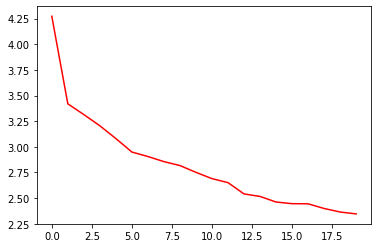

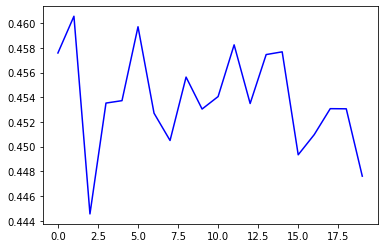

In [ ]:
# пройдено около 80 эпох обучения до полученного ниже результата:

plt.plot(losses[0], 'r')
plt.show()
plt.plot(losses[1], 'b')
plt.show()

In [ ]:
num_epochs = 20 
# так как обучения было с перерывами, то суммарно было пройдено около 100 эпох обучения до полученного ниже результата.

lamb = 10

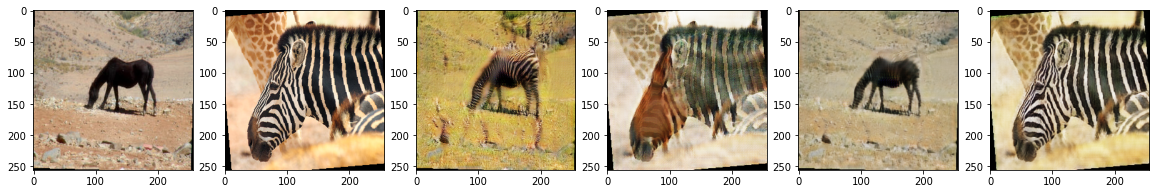

tensor(2.0392)
* Epoch 20/20
[tensor(2.3146), tensor(2.3060), tensor(2.2181), tensor(2.2694), tensor(2.2035), tensor(2.2209), tensor(2.1702), tensor(2.1688), tensor(2.1479), tensor(2.1092), tensor(2.1554), tensor(2.0971), tensor(2.0783), tensor(2.1050), tensor(2.0703), tensor(2.0497), tensor(2.0694), tensor(2.0640), tensor(2.0294), tensor(2.0392)]


In [ ]:
### Запуск обучения нашей нейросети ###

losses = train(GA2B, GB2A, D1, D2, num_epochs, data_train_A, data_train_B, batch_size, lamb, loss_g, loss_d)

# пройдено около 100 эпох обучения до полученного ниже результата:

Выше расположены изображения в следующем порядке (слева-направо):

1. фото реальной лошади (x)
2. фото реальной зебры (Y)
3. генерация изображения зебры из фото реальной лошади (fake_y = GA2B(X))
4. генерация изображения лошади из фото реальной зебры (fake_x = GB2A(y))
5. генерация изображения лошади из сгенерированного изображения зебры (fake_x2 = GB2A(fake_y))
6. генерация изображения зебры из сгенерированного изображения лошади (fake_y2 = GA2B(fake_x))

In [ ]:
num_epochs = 20 
# так как обучения было с перерывами, то суммарно было пройдено около 120 эпох обучения до полученного ниже результата.

lamb = 10

In [ ]:
### Запуск обучения нашей нейросети ###

losses = train(GA2B, GB2A, D1, D2, num_epochs, data_train_A, data_train_B, batch_size, lamb, loss_g, loss_d)

# пройдено около 120 эпох обучения до полученного ниже результата:

tensor(2.0020)
* Epoch 20/20
[tensor(2.2330), tensor(2.2164), tensor(2.2068), tensor(2.1980), tensor(2.1724), tensor(2.1998), tensor(2.1551), tensor(2.1282), tensor(2.1007), tensor(2.1437), tensor(2.0708), tensor(2.0653), tensor(2.0545), tensor(2.0393), tensor(2.0114), tensor(2.0267), tensor(2.0340), tensor(1.9869), tensor(2.0082), tensor(2.0020)]


Выше расположены изображения в следующем порядке (слева-направо):

1. фото реальной лошади (x)
2. фото реальной зебры (Y)
3. генерация изображения зебры из фото реальной лошади (fake_y = GA2B(X))
4. генерация изображения лошади из фото реальной зебры (fake_x = GB2A(y))
5. генерация изображения лошади из сгенерированного изображения зебры (fake_x2 = GB2A(fake_y))
6. генерация изображения зебры из сгенерированного изображения лошади (fake_y2 = GA2B(fake_x))

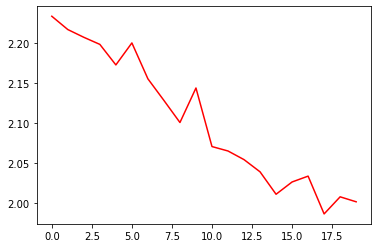

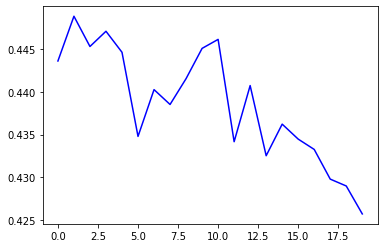

In [ ]:
# пройдено около 120 эпох обучения до полученного ниже результата:

plt.plot(losses[0], 'r')
plt.show()
plt.plot(losses[1], 'b')
plt.show()

In [ ]:
num_epochs = 30
# так как обучения было с перерывами, то суммарно было пройдено около 150 эпох обучения до полученного ниже результата.

lamb = 10

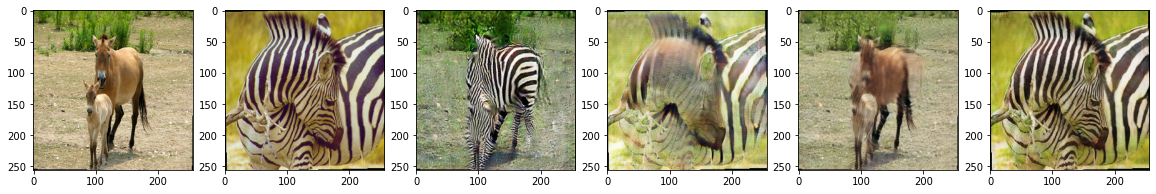

tensor(2.0263)
* Epoch 30/30
[tensor(2.2242), tensor(2.1813), tensor(2.1727), tensor(2.2350), tensor(2.2191), tensor(2.1393), tensor(2.1414), tensor(2.1582), tensor(2.1377), tensor(2.1074), tensor(2.1146), tensor(2.1204), tensor(2.0723), tensor(2.0721), tensor(2.0544), tensor(2.0458), tensor(2.0627), tensor(2.0504), tensor(2.0342), tensor(2.0102), tensor(2.0179), tensor(2.0473), tensor(1.9965), tensor(2.0077), tensor(2.0381), tensor(1.9966), tensor(2.0103), tensor(2.0183), tensor(2.0337), tensor(2.0263)]


In [ ]:
### Запуск обучения нашей нейросети ###

losses = train(GA2B, GB2A, D1, D2, num_epochs, data_train_A, data_train_B, batch_size, lamb, loss_g, loss_d)

# пройдено около 150 эпох обучения до полученного ниже результата:

Выше расположены изображения в следующем порядке (слева-направо):

1. фото реальной лошади (x)
2. фото реальной зебры (Y)
3. генерация изображения зебры из фото реальной лошади (fake_y = GA2B(X))
4. генерация изображения лошади из фото реальной зебры (fake_x = GB2A(y))
5. генерация изображения лошади из сгенерированного изображения зебры (fake_x2 = GB2A(fake_y))
6. генерация изображения зебры из сгенерированного изображения лошади (fake_y2 = GA2B(fake_x))

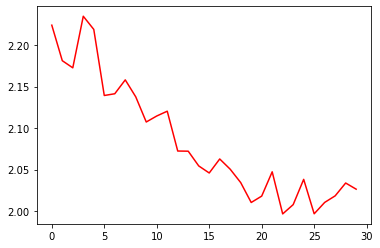

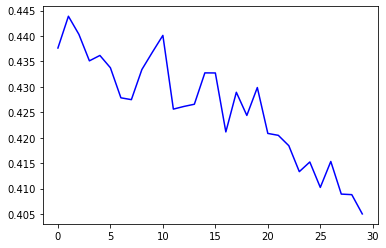

In [ ]:
# пройдено около 150 эпох обучения до полученного ниже результата:

plt.plot(losses[0], 'r')
plt.show()
plt.plot(losses[1], 'b')
plt.show()

In [ ]:
num_epochs = 50
# так как обучения было с перерывами, то суммарно было пройдено около 200 эпох обучения до полученного ниже результата.

lamb = 10

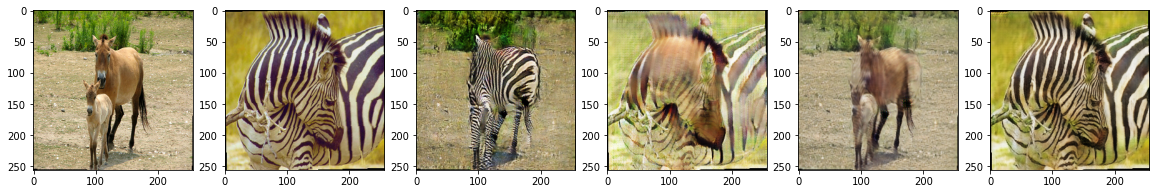

tensor(2.0224)
* Epoch 50/50
[tensor(2.2061), tensor(2.2581), tensor(2.1441), tensor(2.1827), tensor(2.1866), tensor(2.1592), tensor(2.1427), tensor(2.1657), tensor(2.1588), tensor(2.1134), tensor(2.1369), tensor(2.1176), tensor(2.1289), tensor(2.1372), tensor(2.1254), tensor(2.1208), tensor(2.1199), tensor(2.1301), tensor(2.0679), tensor(2.1062), tensor(2.0884), tensor(2.1069), tensor(2.1164), tensor(2.0974), tensor(2.0929), tensor(2.0664), tensor(2.0721), tensor(2.0778), tensor(2.0616), tensor(2.0860), tensor(2.0725), tensor(2.0417), tensor(2.0626), tensor(2.0443), tensor(2.0536), tensor(2.0648), tensor(2.0387), tensor(2.0396), tensor(2.0301), tensor(2.0349), tensor(2.0273), tensor(2.0330), tensor(2.0282), tensor(2.0274), tensor(2.0514), tensor(2.0332), tensor(2.0266), tensor(2.0365), tensor(2.0436), tensor(2.0224)]


In [ ]:
### Запуск обучения нашей нейросети ###

losses = train(GA2B, GB2A, D1, D2, num_epochs, data_train_A, data_train_B, batch_size, lamb, loss_g, loss_d)

# пройдено около 200 эпох обучения до полученного ниже результата:

Выше расположены изображения в следующем порядке (слева-направо):

1. фото реальной лошади (x)
2. фото реальной зебры (Y)
3. генерация изображения зебры из фото реальной лошади (fake_y = GA2B(X))
4. генерация изображения лошади из фото реальной зебры (fake_x = GB2A(y))
5. генерация изображения лошади из сгенерированного изображения зебры (fake_x2 = GB2A(fake_y))
6. генерация изображения зебры из сгенерированного изображения лошади (fake_y2 = GA2B(fake_x))

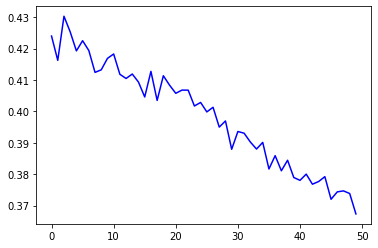

In [ ]:
# пройдено около 200 эпох обучения до полученного ниже результата:

plt.plot(losses[0], 'r')
plt.show()
plt.plot(losses[1], 'b')
plt.show()

In [ ]:
num_epochs = 50
# так как обучения было с перерывами, то суммарно было пройдено около 250 эпох обучения до полученного ниже результата.

lamb = 10

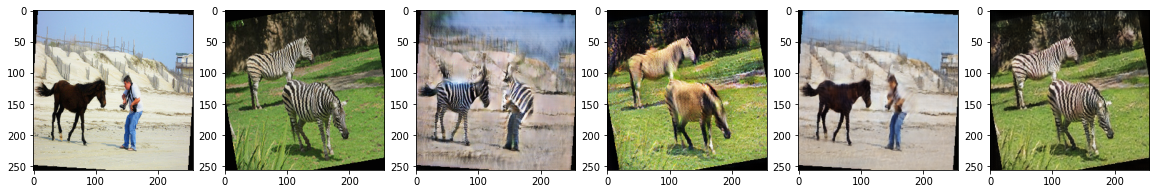

tensor(2.1799)


In [ ]:
### Запуск обучения нашей нейросети ###

losses = train(GA2B, GB2A, D1, D2, num_epochs, data_train_A, data_train_B, batch_size, lamb, loss_g, loss_d)

# пройдено около 250 эпох обучения до полученного ниже результата:

Выше расположены изображения в следующем порядке (слева-направо):

1. фото реальной лошади (x)
2. фото реальной зебры (Y)
3. генерация изображения зебры из фото реальной лошади (fake_y = GA2B(X))
4. генерация изображения лошади из фото реальной зебры (fake_x = GB2A(y))
5. генерация изображения лошади из сгенерированного изображения зебры (fake_x2 = GB2A(fake_y))
6. генерация изображения зебры из сгенерированного изображения лошади (fake_y2 = GA2B(fake_x))

In [ ]:
num_epochs = 50
# так как обучения было с перерывами, то суммарно было пройдено около 300 эпох обучения до полученного ниже результата.

lamb = 10

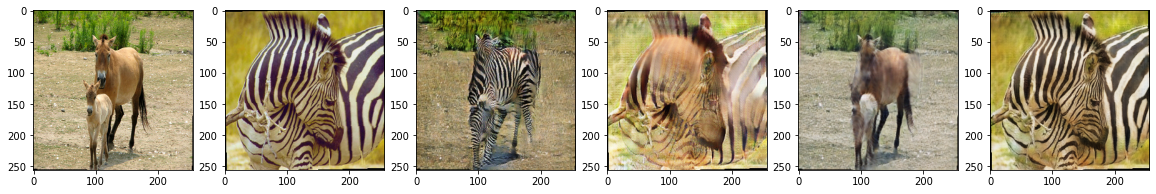

tensor(2.0429)
* Epoch 50/50
[tensor(2.2631), tensor(2.3003), tensor(2.2457), tensor(2.2611), tensor(2.2337), tensor(2.2859), tensor(2.2610), tensor(2.2523), tensor(2.2718), tensor(2.2298), tensor(2.2628), tensor(2.2318), tensor(2.2365), tensor(2.2589), tensor(2.2064), tensor(2.2255), tensor(2.2277), tensor(2.1890), tensor(2.1988), tensor(2.1553), tensor(2.1864), tensor(2.1697), tensor(2.1672), tensor(2.1742), tensor(2.1588), tensor(2.1442), tensor(2.1663), tensor(2.1327), tensor(2.1203), tensor(2.1257), tensor(2.1273), tensor(2.1254), tensor(2.1123), tensor(2.1206), tensor(2.1243), tensor(2.1001), tensor(2.0978), tensor(2.1027), tensor(2.0913), tensor(2.0858), tensor(2.0733), tensor(2.0898), tensor(2.0741), tensor(2.0696), tensor(2.0667), tensor(2.0822), tensor(2.0483), tensor(2.0600), tensor(2.0508), tensor(2.0429)]


In [ ]:
### Запуск обучения нашей нейросети ###

losses = train(GA2B, GB2A, D1, D2, num_epochs, data_train_A, data_train_B, batch_size, lamb, loss_g, loss_d)

# пройдено около 300 эпох обучения до полученного ниже результата:

Выше расположены изображения в следующем порядке (слева-направо):

1. фото реальной лошади (x)
2. фото реальной зебры (Y)
3. генерация изображения зебры из фото реальной лошади (fake_y = GA2B(X))
4. генерация изображения лошади из фото реальной зебры (fake_x = GB2A(y))
5. генерация изображения лошади из сгенерированного изображения зебры (fake_x2 = GB2A(fake_y))
6. генерация изображения зебры из сгенерированного изображения лошади (fake_y2 = GA2B(fake_x))

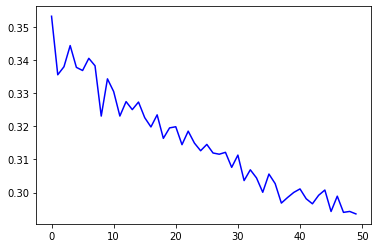

In [ ]:
# пройдено около 300 эпох обучения до полученного ниже результата:

plt.plot(losses[0], 'r')
plt.show()
plt.plot(losses[1], 'b')
plt.show()

### Валидация наших моделей

In [ ]:
# dir_test_A = Path('horse2zebra_/testA')
# dir_test_B = Path('horse2zebra_/testB')

In [ ]:
# test_A = sorted(list(dir_test_A.rglob('*.jpg')))
# test_B = sorted(list(dir_test_B.rglob('*.jpg')))

In [ ]:
# dataset_test_A = dataset(test_A, mode = 'test')
# dataset_test_B = dataset(test_B, mode = 'test')

In [ ]:
# batch_size = 4

## data_test_A = DataLoader(dataset_test_A, batch_size = batch_size, shuffle = False)
## data_test_B = DataLoader(dataset_test_B, batch_size = batch_size, shuffle = False)

# data_test_A = DataLoader(dataset_test_A, batch_size = batch_size, shuffle = True)
# data_test_B = DataLoader(dataset_test_B, batch_size = batch_size, shuffle = True)

In [ ]:
# print('testA = ', len(test_A))
# print('testB = ', len(test_B))

testA =  140
testB =  140


In [ ]:
##### Функция TEST для нашей сети, состоящей из моделей дескриминаторов D1, D2 и генераторов GA2B, GB2A #####

def test(GA2B, GB2A, D1, D2, num__test_epochs, data_test_A, data_test_B, batch_size, lamb, loss_g, loss_d):

    # Очистить кэш предварительно перед обучением
    # torch.cuda.empty_cache()

    # torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.enabled = True

    # evaluate models:
    GA2B.eval() # переводим модель генератора в режим eval() - генерация изображения зебры из фото реальной лошади
    GB2A.eval() # переводим модель генератора в режим eval() - генерация изображения лошади из фото реальной зебры
    D1.eval() # переводим модель дискриминатора в режим eval()
    D2.eval() # переводим модель дискриминатора в режим eval()


    losses_test = [[], []]
    i = 0
    epoch = 0

    ### for epoch in range(0, num_epochs):
    for epoch in range(num_test_epochs):

        loss_test = [[], []]

        for x, Y in zip(data_test_A, data_test_B):

            with torch.set_grad_enabled(False):
            # with torch.no_grad():

                # for param in GA2B.parameters():
                #    param.requires_grad = True
                # for param in GB2A.parameters():
                #    param.requires_grad = True
                # for param in D1.parameters():
                #    param.requires_grad = False
                # for param in D2.parameters():
                #    param.requires_grad = False

                x, Y = x.to(device), Y.to(device)
                X, y = x.to(device), Y.to(device)

                real_y = GA2B(y).to(device)
                loss_y2y = loss_g(real_y, y)
                real_x = GB2A(X).to(device)
                loss_x2x = loss_g(real_x, X)

                fake_y = GA2B(X).to(device)
                predfor_y = D1(fake_y).to(device)

                clear_output(wait=True)

                fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))
                
                f = x[i].cpu().detach().numpy() / 2 + 0.5
                f = np.rollaxis(f, axis=2)
                f = np.rollaxis(f, axis=2)
                axes[0].imshow(f)

                f = Y[i].cpu().detach().numpy() / 2 + 0.5
                f = np.rollaxis(f, axis=2)
                f = np.rollaxis(f, axis=2)
                axes[1].imshow(f)

                f = fake_y[i].cpu().detach().numpy() / 2 + 0.5
                f = np.rollaxis(f, axis=2)
                f = np.rollaxis(f, axis=2)
                axes[2].imshow(f)

                loss_d1 = loss_d(predfor_y, torch.FloatTensor([1 for i in range(batch_size)]).to(device).view(1, -1))

                fake_x = GB2A(y).to(device)
                predfor_x = D2(fake_x).to(device)
                f = fake_x[i].cpu().detach().numpy() / 2 + 0.5
                f = np.rollaxis(f, axis=2)
                f = np.rollaxis(f, axis=2)
                axes[3].imshow(f)

                loss_d2 = loss_d(predfor_x, torch.FloatTensor([1 for i in range(batch_size)]).to(device).view(1, -1))

                fake_x2 = GB2A(fake_y).to(device)
                loss_cycle_a = loss_g(X, fake_x2)
                f = fake_x2[i].cpu().detach().numpy() / 2 + 0.5
                f = np.rollaxis(f, axis=2)
                f = np.rollaxis(f, axis=2)
                axes[4].imshow(f)

                fake_y2 = GA2B(fake_x).to(device)
                loss_cycle_b = loss_g(y, fake_y2)
                f = fake_y2[i].cpu().detach().numpy() / 2 + 0.5
                f = np.rollaxis(f, axis=2)
                f = np.rollaxis(f, axis=2)
                axes[5].imshow(f)

                plt.show()

                gen_losses = lamb * (loss_cycle_a + loss_cycle_b) + 1 * (loss_d1 + loss_d2) + lamb * 0.5 * (loss_x2x + loss_y2y)


                # for param in GA2B.parameters():
                #    param.requires_grad = False
                # for param in GB2A.parameters():
                #    param.requires_grad = False
                # for param in D1.parameters():
                #    param.requires_grad = True
                # for param in D2.parameters():
                #    param.requires_grad = True

                predreal_x = D1(Y).to(device)
                loss_d21r = loss_d(predreal_x, torch.FloatTensor([1 for i in range(batch_size)]).to(device).view(1, -1))
                predfake_x = D1(GA2B(x)).to(device)
                loss_d21f = loss_d(predfake_x, torch.FloatTensor([0 for i in range(batch_size)]).to(device).view(1, -1))
                l_d1 = (loss_d21r + loss_d21f) * 0.5

                predreal_y = D2(x).to(device)
                loss_d22r = loss_d(predreal_y, torch.FloatTensor([1 for i in range(batch_size)]).to(device).view(1, -1))
                predfake_y = D2(GB2A(Y)).to(device)
                loss_d22f = loss_d(predfake_y , torch.FloatTensor([0 for i in range(batch_size)]).to(device).view(1, -1))
                l_d2 = (loss_d22r + loss_d22f) * 0.5


                i = (i + 1) % batch_size
                loss_test[0].append(gen_losses)
                print(torch.mean(torch.FloatTensor(loss_test[0])))
                loss_test[1].append((l_d1 + l_d2) / 2)


        losses_test[0].append(torch.mean(torch.FloatTensor(loss_test[0])))
        losses_test[1].append(torch.mean(torch.FloatTensor(loss_test[1])))

        ## print(epoch)
        
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, num_test_epochs))

        # plt.plot(losses_test[0])
        print(losses_test[0])

    return losses_test

In [ ]:
# num_test_epochs = 20

# lamb = 10

In [ ]:
### Запуск тестирования (валидации) нашей нейросети ###

# losses_test = test(GA2B, GB2A, D1, D2, num_test_epochs, data_test_A, data_test_B, batch_size, lamb, loss_g, loss_d)

tensor(2.4861)
* Epoch 20/20
[tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861), tensor(2.4861)]


Выше расположены изображения в следующем порядке (слева-направо):

1. фото реальной лошади (x)
2. фото реальной зебры (Y)
3. генерация изображения зебры из фото реальной лошади (fake_y = GA2B(X))
4. генерация изображения лошади из фото реальной зебры (fake_x = GB2A(y))
5. генерация изображения лошади из сгенерированного изображения зебры (fake_x2 = GB2A(fake_y))
6. генерация изображения зебры из сгенерированного изображения лошади (fake_y2 = GA2B(fake_x))

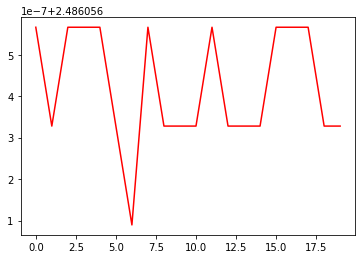

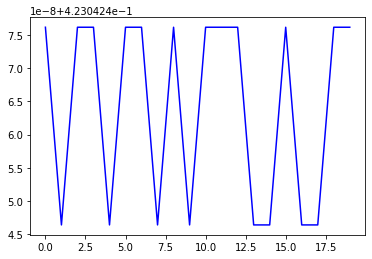

In [ ]:
# Вывод графиков #

plt.plot(losses_test[0], 'r')
plt.show()
plt.plot(losses_test[1], 'b')
plt.show()

### Тестирование наших моделей

In [ ]:
# import copy
# from copy import deepcopy

In [ ]:
##### Функция TEST_new для нашей сети, состоящей из моделей дескриминаторов D1, D2 и генераторов GA2B, GB2A #####

def test_new(GA2B, GB2A, D1, D2, data_test_A, data_test_B, batch_size, n_images):

    # Очистить кэш предварительно перед обучением
    # torch.cuda.empty_cache()

    # torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.enabled = True

    # evaluate models:
    GA2B.eval() # переводим модель генератора в режим eval() - генерация изображения зебры из фото реальной лошади
    GB2A.eval() # переводим модель генератора в режим eval() - генерация изображения лошади из фото реальной зебры
    D1.eval() # переводим модель дискриминатора в режим eval()
    D2.eval() # переводим модель дискриминатора в режим eval()

    i = 0

    ## data_test_A_ = data_test_A.copy()
    ## data_test_B_ = data_test_B.copy()
    # data_test_A_ = deepcopy(data_test_A)
    # data_test_B_ = deepcopy(data_test_B)

    # c = list(zip(data_test_A_, data_test_B_))
    c = list(zip(data_test_A, data_test_B))

    # for x, Y in random.choices(c, k=cycle_images):
    for x, Y in random.sample(c, k=cycle_images):
     
        with torch.set_grad_enabled(False):
        # with torch.no_grad():

            x, Y = x.to(device), Y.to(device)
            X, y = x.to(device), Y.to(device)

            real_y = GA2B(y).to(device)
            real_x = GB2A(X).to(device)

            fake_y = GA2B(X).to(device)
            predfor_y = D1(fake_y).to(device)

            # clear_output(wait=True)

            fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))
            
            f = x[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[0].imshow(f)

            f = Y[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[1].imshow(f)

            f = fake_y[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[2].imshow(f)

            fake_x = GB2A(y).to(device)
            predfor_x = D2(fake_x).to(device)
            f = fake_x[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[3].imshow(f)

            fake_x2 = GB2A(fake_y).to(device)
            f = fake_x2[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[4].imshow(f)

            fake_y2 = GA2B(fake_x).to(device)
            f = fake_y2[i].cpu().detach().numpy() / 2 + 0.5
            f = np.rollaxis(f, axis=2)
            f = np.rollaxis(f, axis=2)
            axes[5].imshow(f)

            plt.show()


            predreal_x = D1(Y).to(device)
            predfake_x = D1(GA2B(x)).to(device)

            predreal_y = D2(x).to(device)
            predfake_y = D2(GB2A(Y)).to(device)


            i = (i + 1) % batch_size
  
        tic = time()


In [ ]:
# cycle_images = 1 # количество циклов вывода изображений на экран

In [ ]:
### Запуск тестирования нашей нейросети (вывод изображений на экран) ###

# losses_test_new = test_new(GA2B, GB2A, D1, D2, data_test_A, data_test_B, batch_size, n_images)

Выше расположены изображения в следующем порядке (слева-направо):

1. фото реальной лошади (x)
2. фото реальной зебры (Y)
3. генерация изображения зебры из фото реальной лошади (fake_y = GA2B(X))
4. генерация изображения лошади из фото реальной зебры (fake_x = GB2A(y))
5. генерация изображения лошади из сгенерированного изображения зебры (fake_x2 = GB2A(fake_y))
6. генерация изображения зебры из сгенерированного изображения лошади (fake_y2 = GA2B(fake_x))

In [ ]:
# import logging
# import threading

Введите ниже цифру от 1 до 3: 1 - обучение модели, 2 - валидация модели, 3 - тестирование модели
input number (введите цифру от 1 до 3: 1 - TRAIN, 2 - VAL, 3 - TEST): 3

testA =  140
testB =  140

Введите ниже значение количества циклов вывода изображений на экран для теста
cycle_images: 3



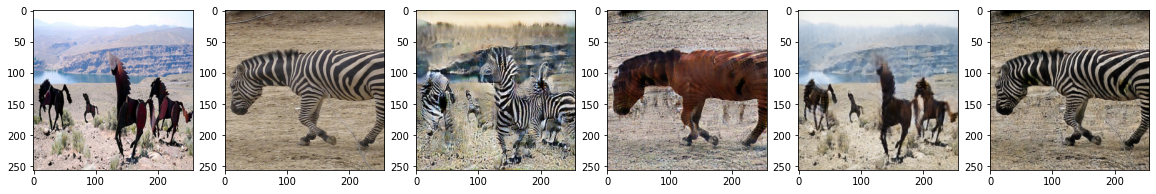

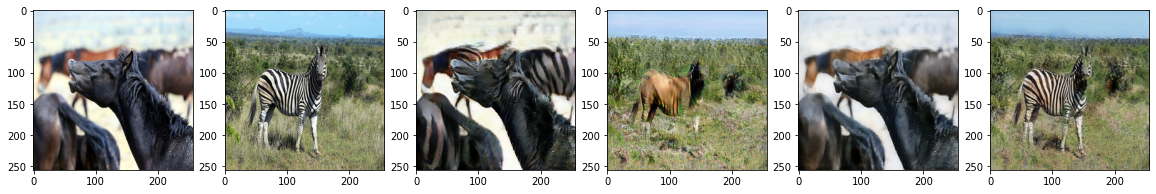

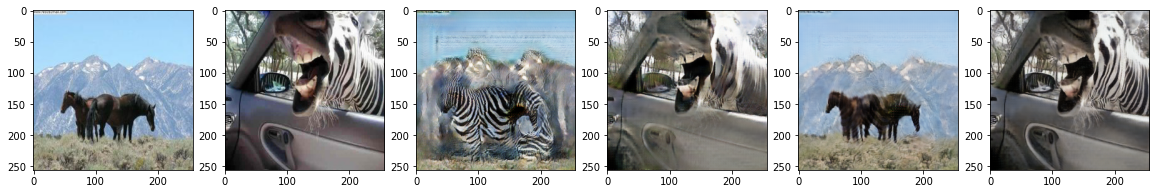


Введите ниже цифру от 1 до 4: 1 - обучение модели, 2 - валидация модели, 3 - тестирование модели, 4 - EXIT 
input number (введите цифру от 1 до 4: 1 - TRAIN, 2 - VAL, 3 - TEST, 4 - EXIT): 4



In [ ]:
print("Введите ниже цифру от 1 до 3: 1 - обучение модели, 2 - валидация модели, 3 - тестирование модели")
tv = int(input("input number (введите цифру от 1 до 3: 1 - TRAIN, 2 - VAL, 3 - TEST): "))
print()

while tv != 4:

    if tv == 1:

        dir_train_A = Path('horse2zebra_/trainA')
        dir_train_B = Path('horse2zebra_/trainB')

        train_A = sorted(list(dir_train_A.rglob('*.jpg')))
        train_B = sorted(list(dir_train_B.rglob('*.jpg')))

        dataset_train_A = dataset(train_A, mode = 'train')
        dataset_train_B = dataset(train_B, mode = 'train')

        batch_size = 4

        data_train_A = DataLoader(dataset_train_A, batch_size = batch_size, shuffle = True)
        data_train_B = DataLoader(dataset_train_B, batch_size = batch_size, shuffle = True)

        print('trainA = ', len(train_A))
        print('trainB = ', len(train_B))
        print()

        ### Задаем функции потерь ###
        loss_g = nn.MSELoss()
        loss_d = nn.L1Loss()

        print("Введите ниже значение количества эпох для дополнительного трейна (p.s. модели уже обучены на 300 эпохах!)")
        num_epochs = int(input("num_epochs: "))
        print()

        # num_epochs = 20
        lamb = 10

        ### Запуск обучения нашей нейросети (ранее уже было пройдено 300 эпох обучения) ###
        losses = train(GA2B, GB2A, D1, D2, num_epochs, data_train_A, data_train_B, batch_size, lamb, loss_g, loss_d)

        # Вывод графиков (ранее уже было пройдено 300 эпох обучения) #
        plt.plot(losses[0], 'r')
        plt.show()
        plt.plot(losses[1], 'b')
        plt.show()


    elif tv == 2:

        dir_test_A = Path('horse2zebra_/testA')
        dir_test_B = Path('horse2zebra_/testB')

        test_A = sorted(list(dir_test_A.rglob('*.jpg')))
        test_B = sorted(list(dir_test_B.rglob('*.jpg')))

        dataset_test_A = dataset(test_A, mode = 'test')
        dataset_test_B = dataset(test_B, mode = 'test')

        batch_size = 4

        # data_test_A = DataLoader(dataset_test_A, batch_size = batch_size, shuffle = False)
        # data_test_B = DataLoader(dataset_test_B, batch_size = batch_size, shuffle = False)
        data_test_A = DataLoader(dataset_test_A, batch_size = batch_size, shuffle = True)
        data_test_B = DataLoader(dataset_test_B, batch_size = batch_size, shuffle = True)

        print('testA = ', len(test_A))
        print('testB = ', len(test_B))
        print()

        ### Задаем функции потерь ###
        loss_g = nn.MSELoss()
        loss_d = nn.L1Loss()

        print("Введите ниже значение количества эпох для валидации")
        num_test_epochs = int(input("num_test_epochs: "))
        print()

        # num_test_epochs = 20
        lamb = 10

        ### Запуск тестирования (валидации) нашей нейросети ###
        losses_test = test(GA2B, GB2A, D1, D2, num_test_epochs, data_test_A, data_test_B, batch_size, lamb, loss_g, loss_d)

        # Вывод графиков #
        plt.plot(losses_test[0], 'r')
        plt.show()
        plt.plot(losses_test[1], 'b')
        plt.show()


    elif tv == 3:

        dir_test_A = Path('horse2zebra_/testA')
        dir_test_B = Path('horse2zebra_/testB')

        test_A = sorted(list(dir_test_A.rglob('*.jpg')))
        test_B = sorted(list(dir_test_B.rglob('*.jpg')))

        dataset_test_A = dataset(test_A, mode = 'test')
        dataset_test_B = dataset(test_B, mode = 'test')

        batch_size = 4

        # data_test_A = DataLoader(dataset_test_A, batch_size = batch_size, shuffle = False)
        # data_test_B = DataLoader(dataset_test_B, batch_size = batch_size, shuffle = False)

        data_test_A = DataLoader(dataset_test_A, batch_size = batch_size, shuffle = True)
        data_test_B = DataLoader(dataset_test_B, batch_size = batch_size, shuffle = True)

        print('testA = ', len(test_A))
        print('testB = ', len(test_B))
        print()

        print("Введите ниже значение количества циклов вывода изображений на экран для теста")
        cycle_images = int(input("cycle_images: "))
        print()

        # cycle_images = 1 # количество циклов вывода изображений на экран

        ### Запуск тестирования нашей нейросети (вывод изображений на экран) ###
        losses_test_new = test_new(GA2B, GB2A, D1, D2, data_test_A, data_test_B, batch_size, cycle_images)

        # time.sleep(3)
        event = threading.Event()
        event.wait(5)

        print()
        print("Введите ниже цифру от 1 до 4: 1 - обучение модели, 2 - валидация модели, 3 - тестирование модели, 4 - EXIT ")
        tv = int(input("input number (введите цифру от 1 до 4: 1 - TRAIN, 2 - VAL, 3 - TEST, 4 - EXIT): "))
        print()


    # elif tv == 4:
        
        # break
